# Importing libraires, loading dataset


In [53]:
import numpy as np
import pandas as pd
import nltk
from tqdm import tqdm
tqdm.pandas()

movies_df = pd.read_csv('datasets/movies_updated.csv')
movies_df_original = pd.read_csv('datasets/movies.csv')

print("Number of movies loaded:", len(movies_df_original))

movies_df_original.head()

Number of movies loaded: 100


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [2]:
# concatting wiki and imdb plot 

movies_df['concatted_plot'] = movies_df["wiki_plot"].astype(str) + "\n" + \
                              movies_df["imdb_plot"].astype(str)
movies_df.head()

,Unnamed: 0,rank,title,genre,wiki_plot,imdb_plot,concatted_plot,tokens
0,0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit...","['On', 'the', 'day', 'of', 'his', 'only', 'dau..."
1,1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ...","['In', 'banker', 'Andy', 'Dufresne', 'is', 'co..."
2,2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the...","['In', 'the', 'Germans', 'move', 'Polish', 'Je..."
3,3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight...","['In', 'a', 'brief', 'scene', 'in', 'an', 'agi..."
4,4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...,"['It', 'is', 'early', 'December', 'American', ..."


# Tokenzation + Lemmatization

In [3]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from collections import defaultdict
import re
  
lemmatizer = WordNetLemmatizer()

In [4]:
# creating dict with parts of speech

tag_dict = defaultdict(lambda:wn.NOUN)
tag_dict['JJ'] = wn.ADJ
tag_dict['VB'] = wn.VERB
tag_dict['RB'] = wn.ADV

In [5]:
def tokenize(input_text):
    # getting default tokens        
    tokens = [word for sent in nltk.sent_tokenize(input_text) for word in nltk.word_tokenize(sent)]
    
    # filter them, get only letters
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]

    # create token to pos_tag tags, because lemmatize accept only wordnet tags
    token_to_tag = {token:list(pos_tag(list(token))[0])[1] for token in filtered_tokens}
    
    # lemmatize token with wordnet tag
    lems = [lemmatizer.lemmatize(token, tag_dict[tag]) for token,tag in token_to_tag.items()]
    
    return lems


In [6]:
tokenize("Today (May 19, 2016) is his only daughter's wedding.")

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [33]:
# movies_df['tokens'] = movies_df.concatted_plot.progress_apply(tokenize)

100%|██████████| 100/100 [06:16<00:00,  3.77s/it]


# Word2Vec implementation

In [8]:
from gensim.models import Word2Vec

#sg hyperparameter =0 means CBoW
x_tokens = [x for x in movies_df["tokens"]]
cbow = Word2Vec(x_tokens, size=50, window=2, sg=0, min_count=1)

In [9]:
def vectorizing_sentences(sentence):
    vectors = []
    for word in sentence:
        if word in cbow.wv.vocab:
            vectors.append(cbow.wv[word])

    average = sum(vectors) / len(vectors)
    return average

In [10]:
movies_df['vector'] = movies_df.tokens.progress_apply(vectorizing_sentences)

100%|██████████| 100/100 [00:02<00:00, 40.71it/s]


# KMeans

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

x_vector = movies_df['vector'].tolist()

## Elbow 

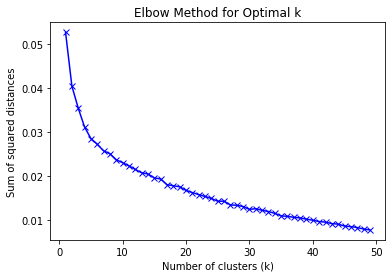

In [12]:
# Calculate the sum of squared distances for different values of k
distortions = []
K = range(1, 50)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_vector)
    distortions.append(kmeans.inertia_)

# Plot the results
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [34]:
# from above diagram we can see that 5 is optimal amount of clusters

km = KMeans(n_clusters=5)

km.fit(x_vector)
clusters = km.labels_.tolist()
movies_df["cluster"] = clusters

movies_df['cluster'].value_counts() 

2    29
4    23
0    22
3    19
1     7
Name: cluster, dtype: int64

# Visualization

## PCA

In [23]:
from sklearn.decomposition import PCA

In [35]:
# Perform PCA with 2 components
pca = PCA(n_components=2)
labels = movies_df['title'].tolist()
pca = pca.fit_transform(x_vector)
x = pca[:,0]
y = pca[:,1]


Text(0, 0.5, 'Y-axis')

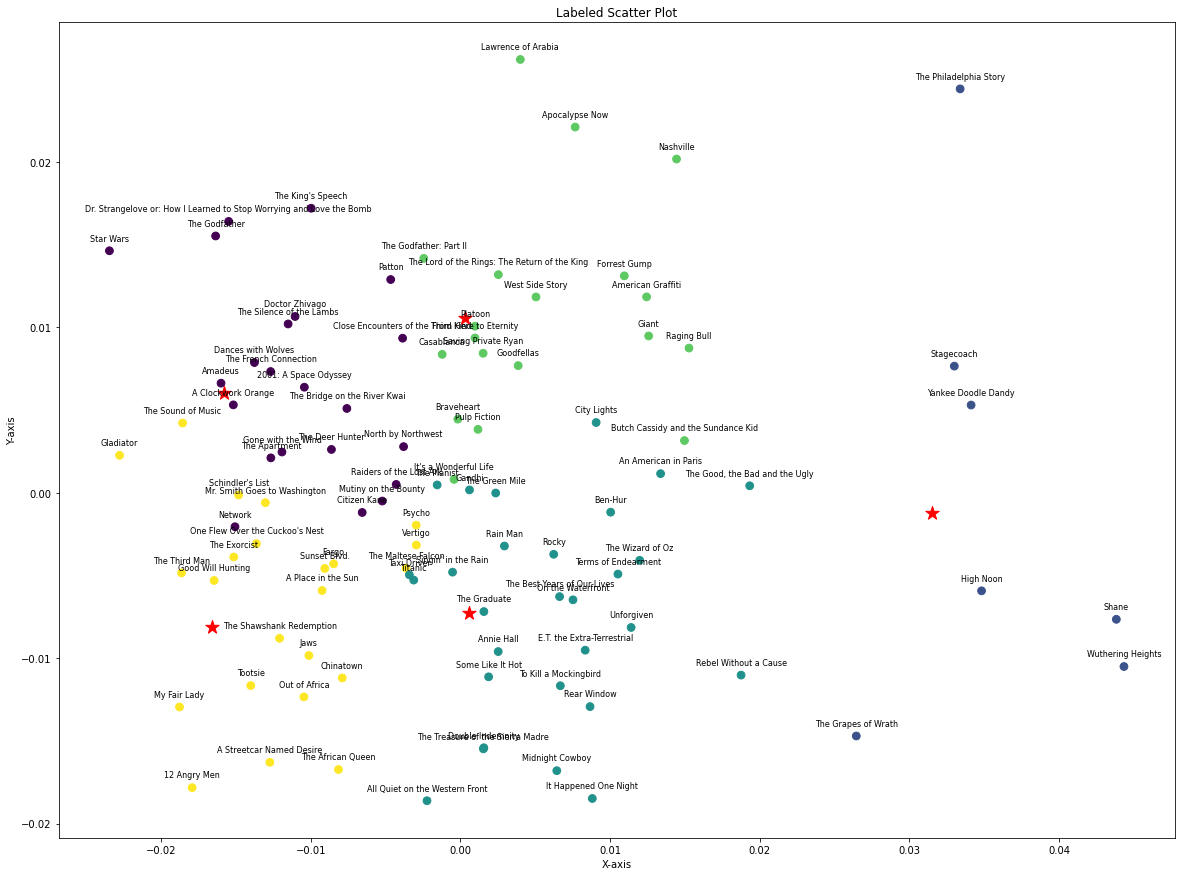

In [36]:
#Pca cluster cetr
pca_center = PCA(n_components=2)
pca_center = pca_center.fit_transform(km.cluster_centers_)

# Create the scatter plot
plt.figure(figsize= (20,15))
plt.scatter(x, y,c=km.labels_, s=60)

# Add labels to each point
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center',fontsize=8)


# Plot the centroids of each cluster
plt.scatter(pca_center[:, 0], pca_center[:, 1], marker='*', s=200, c='red')

# Add title and axis labels
plt.title('Labeled Scatter Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Cosince similarity

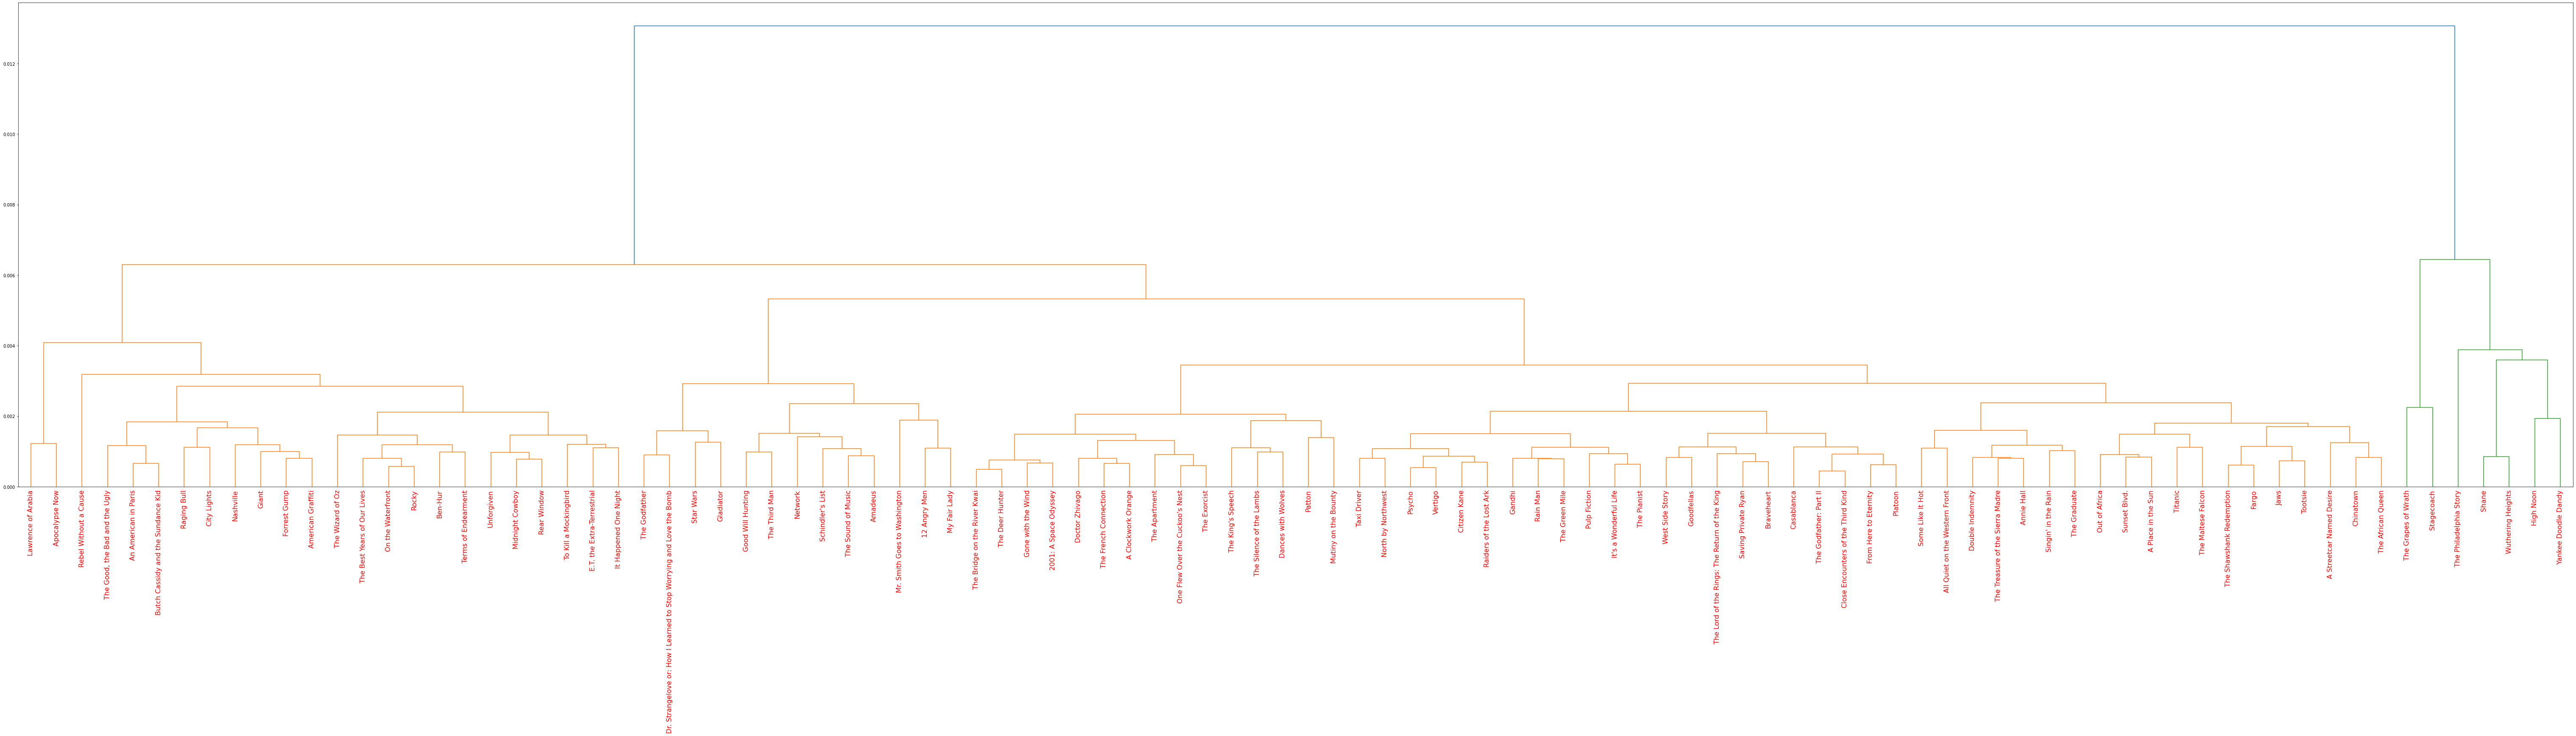

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_distance = 1 - cosine_similarity(x_vector)
from scipy.cluster.hierarchy import linkage, dendrogram

# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show the plotted dendrogram
plt.show()

In [46]:
import seaborn as sns
import numpy as np

# Define a list of vectors
vectors = x_vector
similarity_matrix = np.zeros((len(vectors), len(vectors)))

for i in range(len(vectors)):
    for j in range(len(vectors)):
        similarity_matrix[i][j] = np.dot(vectors[i], vectors[j]) / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))

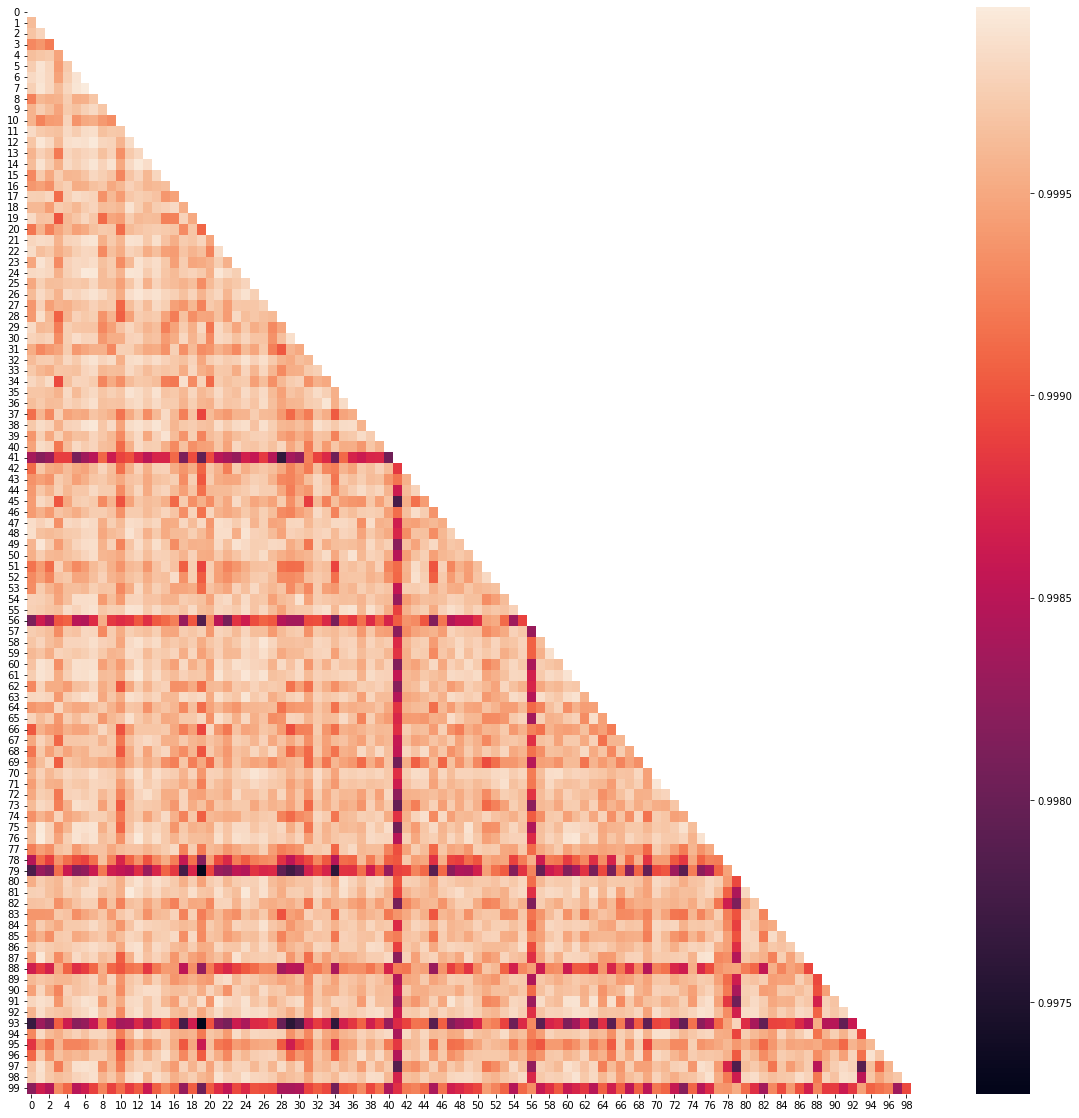

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(similarity_matrix,ax=ax, mask=np.triu(similarity_matrix) )
plt.show()

In [55]:
movies_df.iloc[93]

Unnamed: 0                                                       93
rank                                                             93
title                                             Wuthering Heights
genre                                      [u' Drama', u' Romance']
wiki_plot         A traveller named Lockwood (Miles Mander) is c...
imdb_plot                                                       NaN
concatted_plot    A traveller named Lockwood (Miles Mander) is c...
tokens            ['A', 'traveller', 'named', 'Lockwood', 'Miles...
Name: 93, dtype: object